# Coding up our own CNN

## What you are going to do

In this exercise, you will create algorithms to train non-linear models like CNNs.

In all of the tasks below, you should use PyTorch to design, train and test your CNN models. You can use matplotlib, pandas and numpy to visualize and study your results.



### Import required libraries and packages

In [1]:
# If you run on Jupyter Lab uncomment bellow comment
#! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics"

# If you run on google colab uncomment bellow comment
# !pip install "pytorch-lightning" "torchmetrics"  -qq

# If you are running on your IDE (e.g VSCode) select the virtual environment that you have created as your python kernel
import os

import random

import matplotlib.colors as mpcol

import numpy as np # it's numpy, of course we need it!

import pandas as pd # for handling data

import matplotlib.pyplot as plt # for plotting

import torch # this is PyTorch
import torch.nn as nn # The torch.nn module contains the building blocks for our neural networks
from torch.nn import functional as F # functional is a subpackage that contains various different deep learning functions (e.g activation functions)
from torch import optim # is a package that implements various optimization algorithms used for training
from torch.utils.data.dataset import Dataset # We require the Dataset and DataLoader classes if we are handling custom data
from torch.utils.data import DataLoader

from torchvision import transforms

from pytorch_lightning import seed_everything 

from tqdm import tqdm

# For reproducability
seed_everything(1234, workers=True)

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu') 

Global seed set to 1234


In [2]:
print(device)
print(torch.cuda.is_available())

cuda:0
True


In this section you will be training a Shallow CNN to classify images using the data file "Section1_data.npz", which is the Fashion-MNIST dataset that contains images and labels for training, validation and test purposes (The images are 28x28 grayscale images).

You will use PyTorch's inbuilt datasets class, and Pytorch's module class to construct a CNN in order to perform training and testing on the given datasets using stochastic gradient descent (SGD).

| Type of data | Access |
| --- | --- |
| Train data (inputs) | data['arr_0']  |
| Train data (labels)| data['arr_1'] |
| Validation data (inputs) | data['arr_2']  |
| Validation data (labels)| data['arr_3'] |
| Test data (inputs) | data['arr_4']  |
| Test data (labels)| data['arr_5'] |

### Creating a Pytorch dataset for FashionMNIST

In [7]:
class FashionMNIST(Dataset):
    '''
    Data loader
    '''
    def __init__(self,trn_val_tst = 0, transform=None): 
        '''
        param trn_val_tst (int): integer ID specifying train, validation, test
        param transform (torch vision transform object): optional parameter to further transform input 
        '''
        data = np.load("Section1_data.npz") # make sure to upload the Section1_data.npz file to your working directory!
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0'].T # .T means transpose. Without transposing images they are all black 
            self.labels = data['arr_1'] 
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2'].T
            self.labels = data['arr_3']
        else:
            #testloader
            self.images = data['arr_4'].T
            self.labels = data['arr_5']
        
        # np.asarray converts self.image (or any iterable)
        # -1 is a placeholder signifying "whatever size is needed" 
        # data is converted to dimensions 28,28,1 grid 
        # astype downgrades the data to a lower quality ('float32' data type is a 32-bit floating-point number)
        # normalizing the data: originally [0, 255] (the range for 8-bit image data) dividing by 255 scales the data to the range [0, 1].
        self.images =  np.asarray(self.images).reshape(-1, 28, 28, 1).astype('float32') /255.0 

        # assign the transform object 
        self.transform = transform 

    def __len__(self):
        # Number of labels is the same as the number/len of images
        return len(self.labels) 

    def __getitem__(self, idx):
        # Allowing the dataset to be indexed and return a batch of inputs 
        if torch.is_tensor(idx): 
            idx = idx.tolist()

        # self.images is a two-dimensional array, the first dimension stores the image index and the second stores the image pixel values
        sample = self.images[idx,:] 
        labels = self.labels[idx]

        # Applying transform to batch/sample
        if self.transform:  
            sample = self.transform(sample)
        return sample, labels

In [9]:
# Batch size  
BATCH_SIZE = 128     
N_WORKERS = 0 

# Data augmentations - make sure to transform to tensor!
transform = transforms.Compose([transforms.ToTensor()])

# Create an instance of the FashionMNIST dataset for the training, validation and test set
# Remember we defined FashionMNIST(trn_val_tst = 0, transform=None), use ints 0-2 to define the train/val/test and make sure to pass in the transform
train_set = 0
val_set = 1
test_set = 2

# Now we need to pass the dataset to the Pytorch dataloader class along with some other arguments
# DataLoader(dataset = dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS), make sure to shuffle the train dataset!

# Shuffle training data so the model doesnt learn the order of the dataset
trainloader = DataLoader(dataset = FashionMNIST(train_set, transform), shuffle=True, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
valloader = DataLoader(dataset = FashionMNIST(val_set, transform), shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
testloader = DataLoader(dataset = FashionMNIST(test_set, transform), shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)

### Creating a CNN Model

In [ ]:
'''
output size = floor[(input_width - kernel_width + 2*padding_width)/stride_width + 1]
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
bias=True, padding_mode='zeros', device=None, dtype=None)
'''

![image](network_architecture_hidden.JPG)

In [15]:
class CNN(nn.Module): # This is our main model
    def __init__(self, learning_rate=1e-4):
        super().__init__()

        self.learning_rate = learning_rate
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
        # bias=True, padding_mode='zeros', device=None, dtype=None)

        # in_channels specifies the number of feature maps. out_channels specifies the number of output feature maps (depends on 
        # how many features that we want to search for/extract)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            # output width = floor((28 - 5 + 2(0))/1 + 1) = 24 # after convolution
            # output width = 12 # after 2x2 pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            # output width = floor((12 - 5 + 2(0))/1+1) = 8
            # output width = 4 # after 2x2 pooling

        self.fc1 = nn.Linear(in_features = 512, out_features = 512, bias=True, device=None, dtype=None)
            # in_features = flattened(32*4*4) = 512
            # y = mx + b (m analogous to weight, b analogous to bias)

        self.out = nn.Linear(in_features = 512, out_features = 10, bias=True, device=None, dtype=None)
            # output_features = number of classes in classification task

        # Define Max Pooling (Default stride = kernel size)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Could define custom ReLU: 
        # self.relu = nn.ReLU(...)

    def forward(self, x):
        # conv 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        # conv 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)

        # flatten for linear layers
        x = x.view(x.shape[0],-1)

        # fc1
        x = self.fc1(x)
        x = F.relu(x)

        # output
        out = self.out(x)
        # don't need softmax here since we'll use cross-entropy as our loss function
        return out

### Training our CNN Model

In [16]:
LEARNING_RATE = 1e-3

loss_function = nn.CrossEntropyLoss()

model = CNN(learning_rate=LEARNING_RATE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [18]:
# simple empty array to log the loss
loss_log = []

# Perform 10 epochs
for epoch in range(10):
    loop = tqdm(trainloader)
    for idx, (x_batch, y_batch) in enumerate(loop):
        # perform forward pass
        target_pred = model.forward(x_batch)

        # calc loss
        loss = loss_function(target_pred, y_batch)

        # zero gradients from previous step to avoid adding gradients
        # optimizer stores gradients of previous iterations (each epoch has a respective optimizer)
        optimizer.zero_grad()

        # calculate new gradients
        # backward method does a backward pass
        loss.backward()

        # perform gradient descent
        optimizer.step()

        loss_log.append(loss.item())

print("Loss:", loss.item())

100%|██████████| 469/469 [00:07<00:00, 60.91it/s]

Loss: 0.9734442234039307


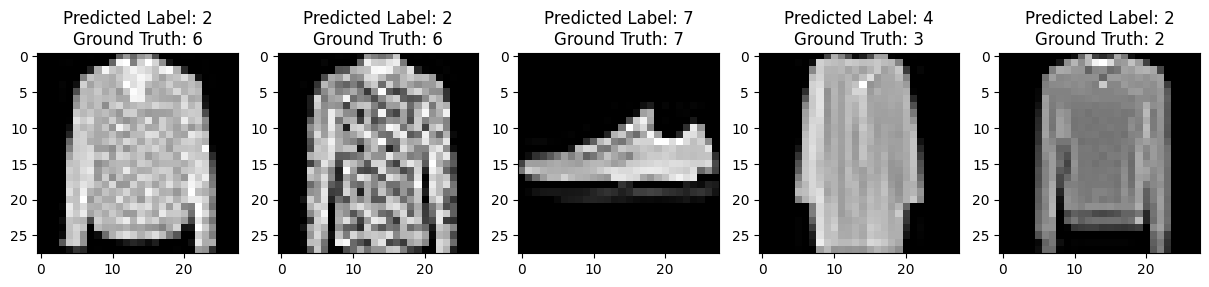

In [19]:
# Generate predictions using predict function
# Take a random test sample
test_data_iterator = iter(testloader)
data, labels = next(test_data_iterator)

predicted_labels = model(data).argmax(1)

data = data.reshape(BATCH_SIZE,28,28) # input data is not in 28x28 format -> for visualisation

input_im = data[0:5] # get first 5 images
ground_truth = labels[0:5] # get labels corresponding to first 5 images
predicted = predicted_labels[0:5] # get predictions corresponding to first 5 images

plt.figure(figsize=(15,8))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(input_im[i], cmap = "gray")
  plt.title(f'Predicted Label: {predicted[i]}\nGround Truth: {ground_truth[i]}')
